# Phenotype t-SNEs + t-type variability

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy
import time
import warnings

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# import tsne
# import sys; import os
# sys.path.append(os.path.expanduser('../FIt-SNE'))
# from fast_tsne import fast_tsne

# import my feature selection function
# sys.path.append('../rna-seq-tsne')
import rnaseqTools

def sns_styleset():
    sns.set(context='paper', style='ticks', font='DejaVu Sans')
    matplotlib.rcParams['axes.linewidth']    = .5
    matplotlib.rcParams['xtick.major.width'] = .5
    matplotlib.rcParams['ytick.major.width'] = .5
    matplotlib.rcParams['xtick.major.size'] = 2
    matplotlib.rcParams['ytick.major.size'] = 2
    matplotlib.rcParams['xtick.minor.size'] = 1
    matplotlib.rcParams['ytick.minor.size'] = 1
    matplotlib.rcParams['font.size']       = 6
    matplotlib.rcParams['axes.titlesize']  = 6
    matplotlib.rcParams['axes.labelsize']  = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['xtick.labelsize'] = 6
    matplotlib.rcParams['ytick.labelsize'] = 6
    matplotlib.rcParams['figure.dpi'] = 120

sns_styleset()

In [4]:
def coverageEllipse(data, coverage=.8, edgecolor=None, facecolor='none', linewidth=1, 
                    zorder=None, robust=False, label=None, fontsize=8, bbox=None, 
                    textcolor='w', labeloffset=(0,0), mineigval=1, linestyle=None):
    multiplier = scipy.stats.chi2.ppf(coverage, 2)

    if robust:
        from sklearn.covariance import MinCovDet
        mcd = MinCovDet(random_state=42).fit(data)
        mu = mcd.location_
        Sigma = mcd.covariance_
    else:
        mu = data.mean(axis=0)
        Sigma = np.cov(data, rowvar=False)

    val, vec = np.linalg.eigh(Sigma)
    val[val<mineigval] = mineigval
    
    width, height = 2 * np.sqrt(val[:, None] * multiplier)
    theta = np.degrees(np.arctan2(*vec[::-1, 0]))
    ellip = matplotlib.patches.Ellipse(xy=mu, width=width, height=height, angle=theta, 
        edgecolor=edgecolor, linewidth=linewidth, facecolor=facecolor, zorder=zorder,
        linestyle=linestyle)
    plt.gca().add_artist(ellip)
    
    if label:
        plt.text(mu[0]+labeloffset[0], mu[1]+labeloffset[1], label, 
                 color=textcolor, fontsize=fontsize, ha='center', va='center', 
                 bbox=bbox, zorder=zorder)
        
    return mu

In [5]:
# Import Patch-seq data

from collections import namedtuple
houstonData = namedtuple('houstonData', 'exonCounts intronCounts cells genes layers cre yields traced \
                                         depth thickness ephys ephysNames exclude \
                                         mice_ages mice_cres morphometrics morphometricsNames zProfiles \
                                         exonLengths intronLengths')
m1 = pickle.load(open('../data/processed/rnaseq/m1.pickle', 'rb'))
ttypes = pickle.load(open('../data/processed/rnaseq/ttypes.pickle', 'rb'))

# M1 cluster colors and names
m1data = pickle.load(open('../data/processed/reduced-allen-data/SmartSeq_cells_AIBS.pickle', 'rb'))
clusterColors = m1data['neurons']['clusterColors']
clusterNames = m1data['neurons']['clusterNames']
clusterN = clusterNames.size

# Define layers based on depth
with np.errstate(invalid='ignore'):
    ourLayers = m1.layers.copy()
    normdepth = m1.depth/m1.thickness
    ourLayers[normdepth < 0.07] = '1'
    ourLayers[(normdepth > 0.07) & (normdepth < 0.29)] = '2/3'
    ourLayers[(normdepth > 0.29) & (normdepth < 0.73)] = '5'
    ourLayers[normdepth > 0.73] = '6'

In [6]:
cols = np.array(['#aaaaaa']*len(m1.cells))
cols[ttypes['type']!=''] = clusterColors[
    ttypes['m1consensus_ass'][~np.isnan(ttypes['m1consensus_ass'])].astype(int)]
cols[m1.exclude!=''] = '#aaaaaa'

shapes = {'1': '^', '2/3': 'o', '5': 's', '6': '+'}
sizes  = {'1': 7,   '2/3': 5,   '5': 4,   '6': 8}
mews   = {'1': 0, '2/3': 0, '5': 0, '6': .75}

tsnedata = {}
tsnes = {}
usedcells = {}

In [7]:
badeph = np.zeros(m1.cells.size).astype(bool)
for t in range(clusterN):
    v = m1.ephys[:, m1.ephysNames=='Resting membrane potential (mV)'][ttypes['type']==clusterNames[t],:]
    if v.size>0:
        v0,v1 = np.percentile(v,[25,75])
        v0 -= 5
        v1 += 5
        ind = (v<v0) | (v>v1)
        badeph[np.where(ttypes['type']==clusterNames[t])[0][ind.flatten()]] = True
np.sum(badeph)

206

## Ephys t-SNE

In [8]:
features_exclude = ['Afterdepolarization (mV)', 'AP Fano factor', 'ISI Fano factor', 
                    'Latency @ +20pA current (ms)', 'Wildness', 'Spike frequency adaptation',
                    'Sag area (mV*s)', 'Sag time (s)', 'Burstiness',
                    'AP amplitude average adaptation index', 'ISI average adaptation index',
                    'Rebound number of APs']
features_log =     ['AP coefficient of variation', 'ISI coefficient of variation', 
                    'ISI adaptation index', 'Latency (ms)']

X = m1.ephys.copy()
print(X.shape)
for e in features_log:
    X[:, m1.ephysNames==e] = np.log(X[:, m1.ephysNames==e])
X = X[:, ~np.isin(m1.ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1)) # & ~badeph # & (m1.exclude=='')
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
X = X / X.std(axis=0)

# for later
ephysTsneFeatures = np.zeros((m1.cells.size, X.shape[1])) * np.nan
ephysTsneFeatures[keepcells,:] = X.copy()
ephysTsneData = np.zeros((m1.cells.size, X.shape[1])) * np.nan
ephysTsneData[keepcells,:] = PCA().fit_transform(X)
ephysTsneData[keepcells,:] /= np.std(ephysTsneData[keepcells,0])

PCinit = PCA(n_components=2, svd_solver='full').fit_transform(X)
PCinit = PCinit / np.std(PCinit[:,0]) * 0.0001
Z = TSNE(init=PCinit, early_exaggeration=4, random_state=42).fit_transform(X)
# Z = fast_tsne(X, seed=42, initialization=PCinit, nbody_algo='Barnes-Hut')

# alpha = 135
# Za = Z @ [[np.cos(alpha * np.pi/180), -np.sin(alpha * np.pi/180)], 
#          [np.sin(alpha * np.pi/180),  np.cos(alpha * np.pi/180)]]

# Z[:,0] *= -1
# Z[:,1] *= -1

tsnes['e'] = Z
usedcells['e'] = keepcells
tsnedata['e'] = ephysTsneData

print(np.sum(keepcells & (ttypes['type']!='') & (m1.exclude=='')))

(1329, 29)
(1320, 17)
1219


<IPython.core.display.Javascript object>


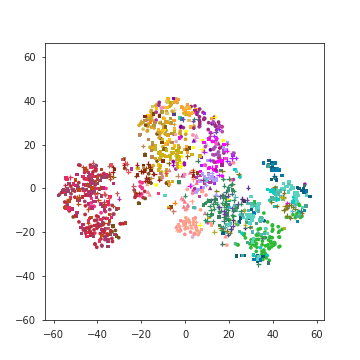

In [9]:
plt.figure(figsize=(3,3))
plt.axis('equal')
typ = 'e'
for L in ['1', '2/3', '5', '6']:
    ind = (ourLayers[usedcells[typ]]==L) & ~np.isnan(ttypes['m1consensus_ass'][usedcells[typ]]) & \
                (m1.exclude[usedcells[typ]] == '')
    s = plt.scatter(tsnes[typ][ind,0], tsnes[typ][ind,1], 
                    c = cols[usedcells[typ]][ind],
                    s=sizes[L], marker=shapes[L], linewidth=mews[L])

## Morph t-SNE

In [12]:
quantified = (np.sum(~np.isnan(m1.morphometrics), axis=1) > 0) # & ~badeph
print(np.sum(quantified))

# not all dendritic features present
quantified[np.isin(m1.cells, ['20180820_sample_1', '20180921_sample_3'])] = False
print(np.sum(quantified))

646
644


In [13]:
inhCells = np.isin(ttypes['family'], ['Pvalb', 'Sst', 'Vip', 'Lamp5', 'Sncg'])
excCells = np.isin(ttypes['family'], ['CT', 'IT', 'NP', 'ET'])

quantified &= (inhCells | excCells)
quantified &= (m1.exclude == '')
print(np.sum(quantified))

inhFeatures = np.sum(~np.isnan(m1.morphometrics[inhCells & quantified,:]),axis=0)>0
excFeatures = np.sum(~np.isnan(m1.morphometrics[excCells & quantified,:]),axis=0)>0

print(np.sum(inhFeatures))
print(np.sum(excFeatures))

print(np.sum(inhCells & quantified))
print(np.sum(excCells & quantified))

inhChunk = m1.morphometrics[inhCells & quantified,:][:, inhFeatures]
excChunk = m1.morphometrics[excCells & quantified,:][:, excFeatures]

inhChunk = inhChunk - inhChunk.mean(axis=0)
inhChunk = inhChunk / inhChunk.std(axis=0)
excChunk = excChunk - excChunk.mean(axis=0)
excChunk = excChunk / excChunk.std(axis=0)

inhPC = PCA(n_components=20).fit_transform(inhChunk)
inhPC /= np.std(inhPC[:,0])
excPC = PCA(n_components=20).fit_transform(excChunk)
excPC /= np.std(excPC[:,0])

excPC += .25

636
50
35
367
269


In [14]:
inhZprof = m1.zProfiles[inhCells & quantified,:]
excZprof = m1.zProfiles[excCells & quantified,:]

inhZPC = PCA(n_components=5).fit_transform(inhZprof)[:,1:]
inhZPC /= np.std(inhZPC[:,0])
excZPC = PCA(n_components=5).fit_transform(excZprof)[:,1:]
excZPC /= np.std(excZPC[:,0])

excZPC += .25

# inhZPC *= .5
# excZPC *= .5

In [15]:
morphTsneData = np.zeros((m1.cells.size, inhPC.shape[1]*2 + inhZPC.shape[1]*2)) + 0
morphTsneData[inhCells & quantified,  0:inhPC.shape[1]] = inhPC
morphTsneData[excCells & quantified, inhPC.shape[1]:inhPC.shape[1]*2] = excPC
morphTsneData[inhCells & quantified, inhPC.shape[1]*2:inhPC.shape[1]*2+inhZPC.shape[1]] = inhZPC
morphTsneData[excCells & quantified, inhPC.shape[1]*2+inhZPC.shape[1]:inhPC.shape[1]*2+inhZPC.shape[1]*2] = excZPC

In [16]:
X = morphTsneData.copy()

keepcells = quantified
X = X[keepcells, :]
print(X.shape)

PCinit = PCA(n_components=2, svd_solver='full').fit_transform(X)
PCinit = PCinit / np.std(PCinit[:,0]) * 0.0001
Z = TSNE(init=PCinit, early_exaggeration=4, random_state=42).fit_transform(X)
# Z = fast_tsne(X, seed=42, initialization=PCinit, nbody_algo='Barnes-Hut')

alpha = -100
Z = Z @ [[np.cos(alpha * np.pi/180), -np.sin(alpha * np.pi/180)], 
         [np.sin(alpha * np.pi/180),  np.cos(alpha * np.pi/180)]]
Z[:,0] *= -1
Z[:,1] *= -1

tsnes['m'] = Z
usedcells['m'] = keepcells
tsnedata['m'] = morphTsneData

(636, 48)


<IPython.core.display.Javascript object>


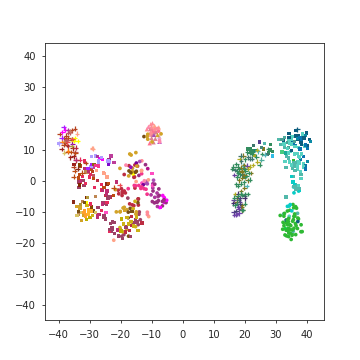

In [17]:
plt.figure(figsize=(3,3))
plt.axis('equal')
typ = 'm'
for L in ['1', '2/3', '5', '6']:
    ind = (ourLayers[usedcells[typ]]==L) & ~np.isnan(ttypes['m1consensus_ass'][usedcells[typ]]) & \
                (m1.exclude[usedcells[typ]] == '')
#     s = plt.scatter(PCinit[ind,0], PCinit[ind,1], 
#                     c = cols[usedcells[typ]][ind],
#                     s=sizes[L], marker=shapes[L], linewidth=mews[L])
    s = plt.scatter(tsnes[typ][ind,0], tsnes[typ][ind,1], 
                    c = cols[usedcells[typ]][ind],
                    s=sizes[L], marker=shapes[L], linewidth=mews[L])

## Combined morph+ephys t-SNE

In [18]:
combinedTsneData = np.concatenate((morphTsneData, ephysTsneData*np.sqrt(2)), axis=1)

keepcells = quantified & ~np.isnan(np.sum(combinedTsneData,axis=1))
X = combinedTsneData[keepcells, :].copy()
print(X.shape)

PCinit = PCA(n_components=2, svd_solver='full').fit_transform(X)
PCinit = PCinit / np.std(PCinit[:,0]) * 0.0001
Z = TSNE(init=PCinit, early_exaggeration=4, random_state=42).fit_transform(X)
# Z = fast_tsne(X, seed=42, initialization=PCinit, nbody_algo='Barnes-Hut', early_exag_coeff=4)

alpha = -10
Z = Z @ [[np.cos(alpha * np.pi/180), -np.sin(alpha * np.pi/180)], 
         [np.sin(alpha * np.pi/180),  np.cos(alpha * np.pi/180)]]
# Z[:,1] *= -1

tsnes['me'] = Z
usedcells['me'] = keepcells
tsnedata['me'] = combinedTsneData

(628, 65)


<IPython.core.display.Javascript object>


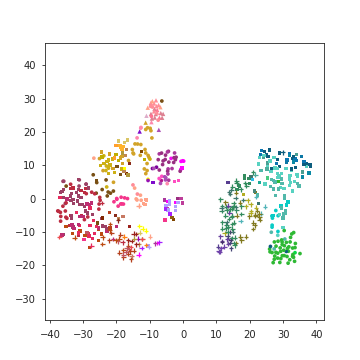

In [19]:
plt.figure(figsize=(3,3))
plt.axis('equal')
typ = 'me'
for L in ['1', '2/3', '5', '6']:
    ind = (ourLayers[usedcells[typ]]==L) & ~np.isnan(ttypes['m1consensus_ass'][usedcells[typ]]) & \
                (m1.exclude[usedcells[typ]] == '')
    s = plt.scatter(tsnes[typ][ind,0], tsnes[typ][ind,1], 
                    c = cols[usedcells[typ]][ind],
                    s=sizes[L], marker=shapes[L], linewidth=mews[L])

## Combined figure

In [20]:
grouping = {}

grouping['e'] = {}
grouping['m'] = {}
grouping['me'] = {'L2/3 IT_3': ['L2/3 IT_3'],
                  'L5 ET all': ['L5 ET_1', 'L5 ET_2', 'L5 ET_3', 'L5 ET_4'],
                  'L6b all': ['L6b Col6a1', 'L6b Shisa6_1', 'L6b Shisa6_2', 'L6b Ror1', 'L6b Kcnip1'],
                  'L6 CT all': ['L6 CT Gpr139', 'L6 CT Cpa6', 'L6 CT Grp', 'L6 CT Pou3f2', 'L6 CT Kit_1', 'L6 CT Kit_2'],
                  'L5 IT_1,2': ['L5 IT_1', 'L5 IT_2'],
#                   'L5 IT_3,4': ['L5 IT_3', 'L5 IT_4'],
                  'L6 IT_1': ['L6 IT_1'],
                  'L6 IT_2': ['L6 IT_2'],
                  'L4/5 IT all': ['L4/5 IT_1', 'L4/5 IT_2'],
                  'L6 Pvalb': {'layer':'6', 'class':['Pvalb']},
                  'L5 Pvalb': {'layer':'5', 'class':['Pvalb']},
                  'L6 Sst': {'layer':'6', 'class':['Sst']},
                  'L5 Vip': {'layer':'5', 'class':['Vip']},
                  'L6 Vip': {'layer':'6', 'class':['Vip']},
                  'Lamp5 Slc35d3': ['Lamp5 Slc35d3'],
                  'Lamp5 Pdlim5_2': ['Lamp5 Pdlim5_2'],
                  'L1 Lamp5 rest': ['Lamp5 Pax6', 'Lamp5 Egln3_2', 'Lamp5 Egln3_3', 'Lamp5 Pdlim5_1', 'Lamp5 Lhx6', 'Lamp5 Egln3_1'],
                  'Pvalb Vipr2_2': ['Pvalb Vipr2_2'],
                  'Vip Mybpc1_2': ['Vip Mybpc1_2'],
                  'Vip Sncg': ['Vip Sncg'],
                  'Sst Calb2': ['Sst Calb2'],
                  'Sst Hpse': ['Sst Hpse'],
#                   'Pvalb Gpr149': ['Pvalb Gpr149'],
#                   'Pvalb Calb1_2': ['Pvalb Calb1_2'], 
#                   'Pvalb Reln': ['Pvalb Reln'],
#                   'Pvalb Il1rapl2': ['Pvalb Il1rapl2'],
                  'Sst Myh8/Etv1': ['Sst Myh8_1', 'Sst Etv1', 'Sst Pvalb Etv1'],
                  'Sst Pvalb Calb2': ['Sst Pvalb Calb2'],}

offsets = {}
offsets['me'] = {'L2/3 IT_3': (7,0),
                  'L5 ET all': (0,6),
                  'L6b all': (0,-6),
                  'L6 CT all': (0,11),
                  'L5 IT_1,2': (8,-7),
#                   'L5 IT_3,4': (0,0),
                  'L6 IT_1': (4,4),
                  'L6 IT_2': (-2,-10),
                  'L4/5 IT all': (6,-4),
                  'L6 Pvalb': (-3,-5),
                  'L5 Pvalb': (-9,-5),
                  'L6 Sst': (5,2),
                  'L5 Vip': (5,-1),
                  'L6 Vip': (3,-5),
                  'Lamp5 Slc35d3': (0,-4),
                  'Lamp5 Pdlim5_2': (8,-1),
                  'L1 Lamp5 rest': (8,-3),
                  'Pvalb Vipr2_2': (3,4),
                  'Vip Mybpc1_2': (5,5),
                  'Vip Sncg': (5,0),
                  'Sst Calb2': (-2,8),
                  'Sst Hpse': (-5,5),
                  'Sst Myh8/Etv1': (-3,4),
                  'Sst Pvalb Calb2': (-8,6),}

In [21]:
def plot_tsne(ax, typ, colors=None, legend=False, ellipses=True):

    if colors is None:
        colors = cols[usedcells[typ]]
    
    plt.sca(ax)
    plt.axis('equal')
    for L in ['1', '2/3', '5', '6']:
        ind = (ourLayers[usedcells[typ]]==L) & ~np.isnan(ttypes['m1consensus_ass'][usedcells[typ]]) & \
                (m1.exclude[usedcells[typ]] == '')
        s = plt.scatter(tsnes[typ][ind,0], tsnes[typ][ind,1], 
                        c=colors[ind],
                        s=sizes[L], marker=shapes[L], linewidth=mews[L])

    if legend:
        sc = []
        for L in ['1', '2/3', '5', '6']:
            d = plt.scatter([], [], color='k', marker=shapes[L], s=sizes[L], linewidth=mews[L], label='L'+L)
            sc.append(d)
        leg = plt.legend(handles=sc, fontsize=5, loc='upper right')
        leg.get_frame().set_linewidth(.5)

    plt.xticks([])
    plt.yticks([])
    
#     for c in range(clusterN):
#         ind = m1rna['final_type'][usedcells[typ]] == clusterNames[c]
#         if np.sum(ind)>=10:
#             col = clusterColors[c]
            
#             label = '\n'.join((' '.join(clusterNames[c].split()[:-1]), clusterNames[c].split()[-1]))
# #             dx = offsets[typ][c]      
# #             if np.isnan(dx[0]):
# #                 label = ''
#             coverageEllipse(tsnes[typ][ind, :2], edgecolor=col, fontsize=5, textcolor=col,
#                         label=label, robust=True, coverage=.8, linewidth=.5, zorder=1)
    
#     return
    
    if not ellipses:
        return
    
    for c in grouping[typ]:
        facecolor = 'none'
        if isinstance(grouping[typ][c], list):
            ind = np.isin(ttypes['type'][usedcells[typ]], grouping[typ][c])
            if len(grouping[typ][c])==1:
                linestyle='-'
                facecolor = 'alpha'
            else:
                linestyle='-'
        else:
            ind = (ourLayers[usedcells[typ]] == grouping[typ][c]['layer']) & \
                   np.isin(ttypes['family'][usedcells[typ]], grouping[typ][c]['class'])
            linestyle='-'
            
        if np.sum(ind)>=5:
            col = np.mean([matplotlib.colors.hex2color(clusterColors[clusterNames==t][0])
                           for t in ttypes['type'][usedcells[typ]][ind]], axis=0)
            
            if len(c.split())==4:
                label = '\n'.join((' '.join(c.split()[:-2]), ' '.join(c.split()[-2:])))
            else:
                label = '\n'.join((' '.join(c.split()[:-1]), c.split()[-1]))                
            dx = offsets[typ][c] if c in offsets[typ] else (0,0)    
            if np.isnan(dx[0]):
                label = ''
            if facecolor == 'alpha':
                facecolor = np.concatenate((col, [0.25]))
            coverageEllipse(tsnes[typ][ind, :2], edgecolor=col, fontsize=5, textcolor=col,
                        label=label, labeloffset=dx, linestyle=linestyle, facecolor=facecolor,
                        robust=True, coverage=.8, linewidth=.5, zorder=1)

<IPython.core.display.Javascript object>


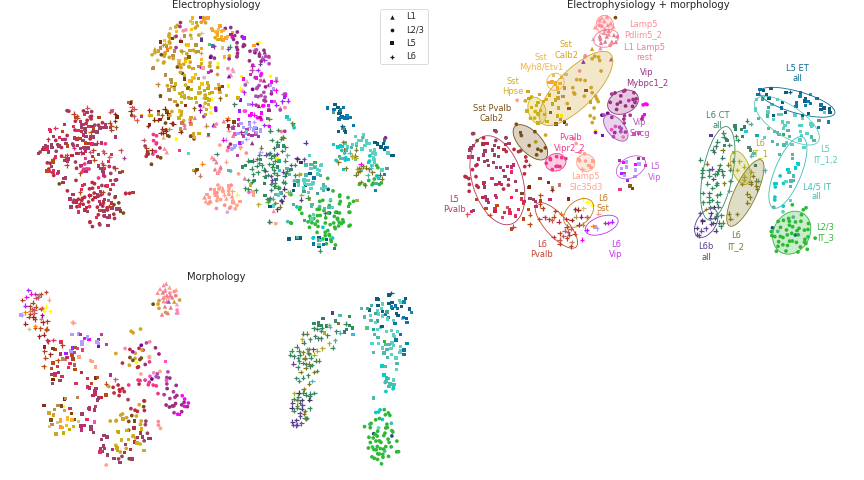

In [22]:
fig = plt.figure(figsize=(7.2, 4))

titles = {'e': 'Electrophysiology', 'm': 'Morphology', 'me': 'Electrophysiology + morphology'}

ax = plt.axes([0, .45, .5, .54])
plot_tsne(ax, 'e', legend=True, ellipses=False)
plt.title(titles['e'], y=.95)
sns.despine(ax=ax, left=True, bottom=True)

ax = plt.axes([0, 0, .5, .44])
plot_tsne(ax, 'm', legend=False, ellipses=False)
plt.title(titles['m'], y=.9)
sns.despine(ax=ax, left=True, bottom=True)

ax = plt.axes([.5, .45, .5, .54])
plot_tsne(ax, 'me', legend=False, ellipses=True)
plt.title(titles['me'], y=.95)
sns.despine(ax=ax, left=True, bottom=True)

<IPython.core.display.Javascript object>


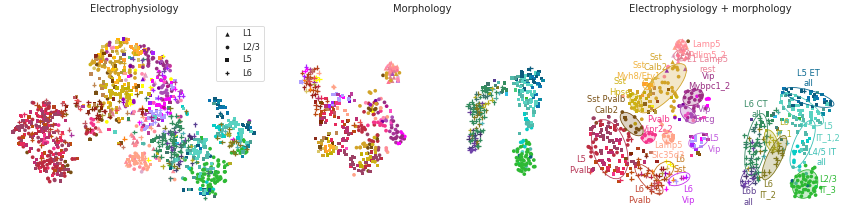

In [23]:
plt.figure(figsize=(7.2, 1.8))
titles = {'e': 'Electrophysiology', 'm': 'Morphology', 'me': 'Electrophysiology + morphology'}

for i,typ in enumerate(['e', 'm', 'me']):
    ax = plt.axes([i/3,0,0.31,.9])
    plot_tsne(ax, typ, legend=(typ=='e'), ellipses=(typ=='me'))
    plt.title(titles[typ])

sns.despine(left=True, bottom=True)

## Family confusion matrices

In [24]:
from sklearn.neighbors import NearestNeighbors

def get_family_confusion(mode, k=10):
    X = tsnedata[mode][usedcells[mode]]
    labels = ttypes['type'][usedcells[mode]]
    classlabels = ttypes['family'][usedcells[mode]]
    
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors()

    classes = np.array(['Lamp5', 'Vip', 'Sst', 'Pvalb', 'IT', 'ET', 'CT'])
    C = np.zeros((classes.size, classes.size))

    for i, cl in enumerate(classes):
        num = 0
        for ind in np.where(classlabels==cl)[0]:
            u, count = np.unique(classlabels[indices[ind,:]], return_counts=True)
            if u[np.argmax(count)] in classes:
                num += 1
                C[i, classes==u[np.argmax(count)]] += 1
        C[i,:] /= num

    return C


def plot_family_confusion(ax, mode, labelfontsize=None, yticklabels=True):
    C = get_family_confusion(mode)
    classes = np.array(['Lamp5', 'Vip', 'Sst', 'Pvalb', 'IT', 'ET', 'CT'])
    
    plt.sca(ax)
    plt.imshow(C, vmin=0, vmax=1, cmap=plt.get_cmap('Greys'))
    plt.xticks([])
    if yticklabels:
        plt.yticks(np.arange(classes.size), classes, fontsize=labelfontsize)
        plt.gca().tick_params(axis='y', length=0)
    else:
        plt.yticks([])
    plt.ylim([-.5, classes.size-.5])
    plt.gca().invert_yaxis()
    
    for i in range(classes.size):
        for j in range(classes.size):
            if C[i,j] >= .05:
                if C[i,j] > .6:
                    col = 'w'
                else:
                    col = 'k'
                plt.text(j,i, '{:2.0f}'.format(100*C[i,j]), fontsize=5, ha='center', va='center', color=col)

<IPython.core.display.Javascript object>


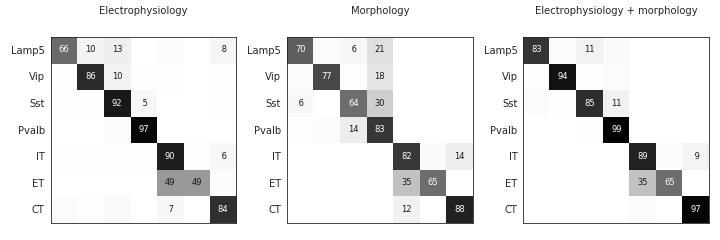

In [25]:
plt.figure(figsize=(6, 2))
titles = {'e': 'Electrophysiology', 'm': 'Morphology', 'me': 'Electrophysiology + morphology'}

for modenum, mode in enumerate(['e', 'm', 'me'], 1):
    ax = plt.subplot(1,3,modenum)
    plot_family_confusion(ax, mode)
    plt.title(titles[mode], y=1.07)
                
plt.tight_layout()
# plt.savefig('figures/knn-classes.png', dpi=300)

# Assemble figure

In [20]:
# plt.figure(figsize=(3.5, 7.5))

# titles = {'e': 'Electrophysiology', 'm': 'Morphology', 'me': 'Electrophysiology + morphology'}

# ax = plt.axes([0, .69, 1, .3])
# plot_tsne(ax, 'e', legend=True, ellipses=False)
# plt.title(titles['e'], y=.95)
# sns.despine(ax=ax, left=True, bottom=True)

# ax = plt.axes([0, .45, 1, .25])
# plot_tsne(ax, 'm', legend=False, ellipses=False)
# plt.title(titles['m'], y=.9)
# sns.despine(ax=ax, left=True, bottom=True)

# ax = plt.axes([0, .15, 1, .3])
# plot_tsne(ax, 'me', legend=False, ellipses=True)
# plt.title(titles['me'])
# sns.despine(ax=ax, left=True, bottom=True)

# # for i,typ in enumerate(['e', 'm', 'me']):
# #     ax = plt.axes([0, .7-i*.25, 1, .25])
# #     plot_tsne(ax, typ, legend=(typ=='e'), ellipses=(typ=='me'))
# #     plt.title(titles[typ])
# #     sns.despine(ax=ax, left=True, bottom=True)
    
# titles = {'e': 'Electrophysiology', 'm': 'Morphology', 'me': 'Combined'}
    
# for i,typ in enumerate(['e', 'm', 'me']):
#     ax = plt.axes([.1+i*.3, 0, .27, .15])
#     plot_family_confusion(ax, typ, yticklabels=(typ=='e'))
#     plt.title(titles[typ], y=.95)
    
# plt.savefig('figures/phenotype-tsnes-vertical.png', dpi=400)

<IPython.core.display.Javascript object>


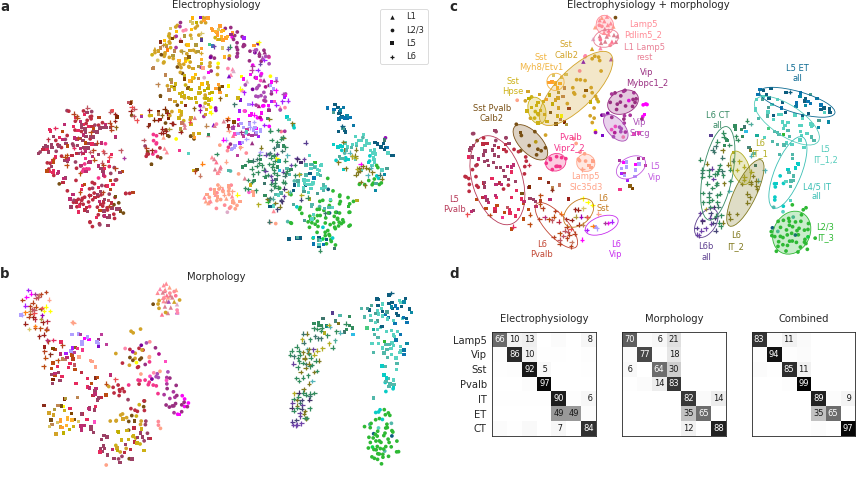

In [26]:
fig = plt.figure(figsize=(7.2, 4))

titles = {'e': 'Electrophysiology', 'm': 'Morphology', 'me': 'Electrophysiology + morphology'}

ax = plt.axes([0, .45, .5, .54])
plot_tsne(ax, 'e', legend=True, ellipses=False)
plt.title(titles['e'], y=.95)
sns.despine(ax=ax, left=True, bottom=True)

ax = plt.axes([0, 0, .5, .44])
plot_tsne(ax, 'm', legend=False, ellipses=False)
plt.title(titles['m'], y=.9)
sns.despine(ax=ax, left=True, bottom=True)

ax = plt.axes([.5, .45, .5, .54])
plot_tsne(ax, 'me', legend=False, ellipses=True)
plt.title(titles['me'], y=.95)
sns.despine(ax=ax, left=True, bottom=True)
    
titles = {'e': 'Electrophysiology', 'm': 'Morphology', 'me': 'Combined'}
    
for i,typ in enumerate(['e', 'm', 'me']):
    ax = plt.axes([.57+i*.15, .05, .12, .3])
    plot_family_confusion(ax, typ, yticklabels=(typ=='e'))
    plt.title(titles[typ])
    
fig.text(0, 1, 'a', fontsize=8, fontweight='bold', va='top')
fig.text(0, .42, 'b', fontsize=8, fontweight='bold')
fig.text(.52, 1, 'c', fontsize=8, fontweight='bold', va='top')
fig.text(.52, .42, 'd', fontsize=8, fontweight='bold')
    
plt.savefig('../figures/mainfigures/phenotype-tsnes.png', dpi=400)

# Type variability

In [27]:
from sklearn.neighbors import NearestNeighbors

def get_type_confusion(mode, k=10, cutoff=10, restrictLayers=False):

    X = tsnedata[mode][usedcells[mode]]
    keepcells = usedcells[mode]
    Z = tsnes[mode]

    classes = np.array(['Lamp5', 'Vip', 'Sst', 'Pvalb', 'IT', 'ET', 'CT'])
    classlabels = ttypes['family'][usedcells[mode]]

    C = np.zeros((clusterN, classes.size)) * np.nan

    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors()

    for t in range(clusterN):
        ind = (ttypes['m1consensus_ass'][keepcells].astype(int) == t)
    
        if np.sum(ind) >= cutoff and restrictLayers:
            l, lc = np.unique(ourLayers[keepcells][ind], return_counts=True)
            mostCommonLayer = l[np.argmax(lc)]
#             if mode=='m' and clusterNames[t] == 'Sst Pvalb Calb2':
#                 print(np.sum(ind))
#                 print(mostCommonLayer)
#                 print(ourLayers[keepcells][ind])
#                 print(np.where(keepcells)[0][ind])
            ind &= (ourLayers[keepcells] == mostCommonLayer)
                
        if np.sum(ind) >= cutoff:
            C[t,:] = 0
            num = 0
            for i in np.where(ind)[0]:
                u, count = np.unique(classlabels[indices[i,:]], return_counts=True)
                if u[np.argmax(count)] in classes:
                    num += 1
                    C[t, classes==u[np.argmax(count)]] += 1
            C[t,:] /= num

    return C
        
        
def plot_type_confusion(ax, mode, ylabelfontsize=None, showylabels=True):
    
    C = get_type_confusion(mode, restrictLayers=(mode!='e'))
    classes = np.array(['Lamp5', 'Vip', 'Sst', 'Pvalb', 'IT', 'ET', 'CT'])

    aboveCutoff = ~np.isnan(C[:,0])

    plt.sca(ax)
    plt.imshow(C[aboveCutoff,:].T, vmin=0, vmax=1, cmap=plt.get_cmap('Greys'), aspect='auto')
    plt.xticks(np.arange(np.sum(aboveCutoff))+.15, clusterNames[aboveCutoff], fontsize=5, rotation=90)
    plt.gca().tick_params(axis='both', length=0)
    if showylabels:
        plt.yticks(np.arange(classes.size), classes, fontsize=ylabelfontsize)
    else:
        plt.yticks([])
    plt.ylim([-.5, classes.size-.5])
    plt.xlim([-.5,np.sum(aboveCutoff)-.5])
    plt.gca().invert_yaxis()

    for i,t in enumerate(np.where(aboveCutoff)[0]):
        if (np.max(C[t,:]) < .75) or (mode=='m' and clusterNames[t]=='L6 IT_2'):
            if t < 60:
                plt.scatter(i,4,marker='^',c='k',s=5)
                plt.plot([i,i], [4,4.6], c='k', linewidth=.8)
            else:
                plt.scatter(i,2,marker='v',c='k',s=5)
                plt.plot([i,i], [2,1.4], c='k', linewidth=.8)

    return C

<IPython.core.display.Javascript object>


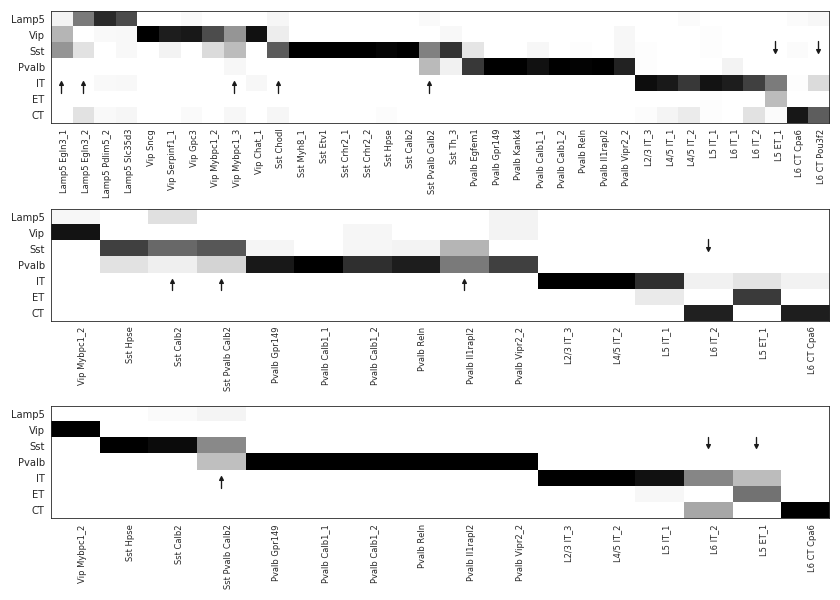

36
16
16


In [28]:
plt.figure(figsize=(7,5))
plt.subplot(311)
C = plot_type_confusion(plt.gca(), 'e')
print(np.sum(~np.isnan(C[:,0])))

plt.subplot(312)
C = plot_type_confusion(plt.gca(), 'm')
print(np.sum(~np.isnan(C[:,0])))

plt.subplot(313)
C = plot_type_confusion(plt.gca(), 'me')
print(np.sum(~np.isnan(C[:,0])))

plt.tight_layout()

# Leiden entropy
Gouwens: 17=13+4 ephys clusters, 38=19+19 morph clusters, 46=26+20 combined clusters

<IPython.core.display.Javascript object>


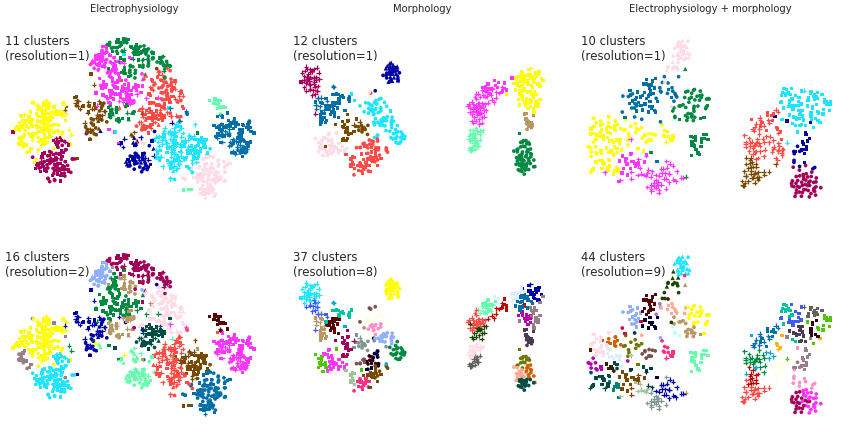

In [51]:
clusterCols = ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
        "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
        "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
        "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
        "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
        "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
        "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
        "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
        "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
        "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
        "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
        "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
        "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
        "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58"]
clusterCols = np.array(clusterCols)

import igraph as ig
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import leidenalg as la

k = 10
resolutions = {}
resolutions['fine']   = {'e': 2, 'm': 8, 'me': 9}
resolutions['coarse'] = {'e': 1, 'm': 1, 'me': 1}

plt.figure(figsize=(7.2, 1.8*2))
titles = {'e': 'Electrophysiology', 'm': 'Morphology', 'me': 'Electrophysiology + morphology'}

for i,typ in enumerate(['e', 'm', 'me']):
    # kNN graph construction
    A = kneighbors_graph(tsnedata[typ][usedcells[typ]],k)
    sources, targets = A.nonzero()
    G = ig.Graph(directed=True)
    G.add_vertices(A.shape[0])
    edges = list(zip(sources, targets))
    G.add_edges(edges)

    for j,res in enumerate(['coarse', 'fine']):
    
        partition = la.find_partition(G, la.RBConfigurationVertexPartition, 
                                  resolution_parameter = resolutions[res][typ], seed=42)
    
        ax = plt.axes([i/3,.5*(1-j),0.31,.45])
        plot_tsne(ax, typ, ellipses=False, colors=clusterCols[partition.membership])

        if j==0:
            plt.title(titles[typ])
        
        plt.text(.02,.8, '{} clusters\n(resolution={})'.format(
             len(np.unique(partition.membership)), resolutions[res][typ]), 
             transform=ax.transAxes, fontsize=7, ha='left')
    
sns.despine(left=True, bottom=True)
# plt.savefig('figures/phenotype-tsnes-leiden.png', dpi=400)

In [52]:
%%time

nrep = 100
k = 10

partitions = {}
partNumber = {}

for typ in ['e', 'm', 'me']:
    # kNN graph construction
    A = kneighbors_graph(tsnedata[typ][usedcells[typ]],k)
    sources, targets = A.nonzero()
    G = ig.Graph(directed=True)
    G.add_vertices(A.shape[0])
    edges = list(zip(sources, targets))
    G.add_edges(edges)
    
    partitions[typ] = {}
    partNumber[typ] = {}
    
    for res in ['coarse', 'fine']:
        p = np.zeros((np.sum(usedcells[typ]), nrep))
        pn = np.zeros(nrep)

        for i in range(nrep):
            partition = la.find_partition(G, la.RBConfigurationVertexPartition, 
                                  resolution_parameter = resolutions[res][typ], seed = i)
            p[:,i] = partition.membership
            pn[i] = np.unique(partition.membership).size
    
        print('{:2} {:6}: median {:4.1f}, min {:2.0f}, max {:2.0f}'.format(typ, res,
            np.median(pn), np.min(pn), np.max(pn)))
        
        partitions[typ][res] = p
        partNumber[typ][res] = pn

e  coarse: median  9.0, min  9, max 11
e  fine  : median 16.0, min 14, max 19
m  coarse: median 12.0, min 10, max 13
m  fine  : median 37.0, min 32, max 42
me coarse: median  9.0, min  8, max 11
me fine  : median 44.5, min 41, max 48
CPU times: user 11.3 s, sys: 4.22 ms, total: 11.3 s
Wall time: 11.3 s


In [54]:
from scipy.stats import entropy

def get_type_entropies(mode, k=10, cutoff=10, restrictLayers=False):

    X = tsnedata[mode][usedcells[mode]]
    keepcells = usedcells[mode]
    Z = tsnes[mode]

    classes = np.array(['Lamp5', 'Vip', 'Sst', 'Pvalb', 'IT', 'ET', 'CT'])
    classlabels = ttypes['family'][usedcells[mode]]

    C = np.zeros((clusterN, nrep)) * np.nan

    for t in range(clusterN):
        ind = (ttypes['m1consensus_ass'][keepcells].astype(int) == t)
    
        if np.sum(ind) >= cutoff and restrictLayers:
            l, lc = np.unique(ourLayers[keepcells][ind], return_counts=True)
            mostCommonLayer = l[np.argmax(lc)]
            ind &= (ourLayers[keepcells] == mostCommonLayer)
        
        if np.sum(ind) >= cutoff:
            for i in range(nrep):
                np.random.seed(i)
                subset = np.random.choice(np.sum(ind), size=cutoff, replace=False)
                _, prob = np.unique(partitions[mode]['fine'][:,i][ind][subset], return_counts=True)
                C[t, i] = entropy(prob)

    return C


def plot_type_entropies(ax, mode, showxlabels=True, showylabel=True):
    C = get_type_entropies(mode, restrictLayers=(mode!='e'))
    aboveCutoff = ~np.isnan(C[:,0])
    
    plt.sca(ax)
    for i,t in enumerate(np.where(aboveCutoff)[0]):
        plt.scatter(i+C[t,:]*0, C[t,:], c=clusterColors[t], s=1, edgecolors='none', clip_on=False)
        plt.scatter(i, np.median(C[t,:]), c=clusterColors[t], s=10, edgecolors='k', 
                    linewidth=.5, clip_on=False, zorder=5)
        
    if showxlabels:
        plt.xticks(np.arange(np.sum(aboveCutoff)), clusterNames[aboveCutoff], fontsize=5, rotation=90)
    else:
        plt.xticks([])
    plt.ylim([0,2])
    plt.xlim([-.5,np.sum(aboveCutoff)-.5])
    if showylabel:
        plt.ylabel('Entropy')
    else:
        plt.yticks([0,1,2], [])
    sns.despine(ax=ax)

<IPython.core.display.Javascript object>


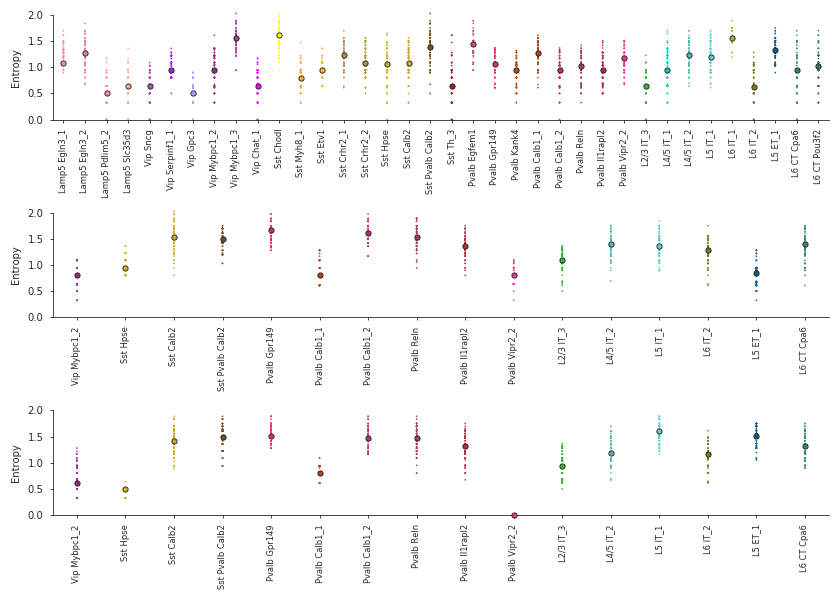

In [55]:
plt.figure(figsize=(7,5))
plt.subplot(311)
plot_type_entropies(plt.gca(), 'e')

plt.subplot(312)
plot_type_entropies(plt.gca(), 'm')

plt.subplot(313)
plot_type_entropies(plt.gca(), 'me')

plt.tight_layout()

<IPython.core.display.Javascript object>


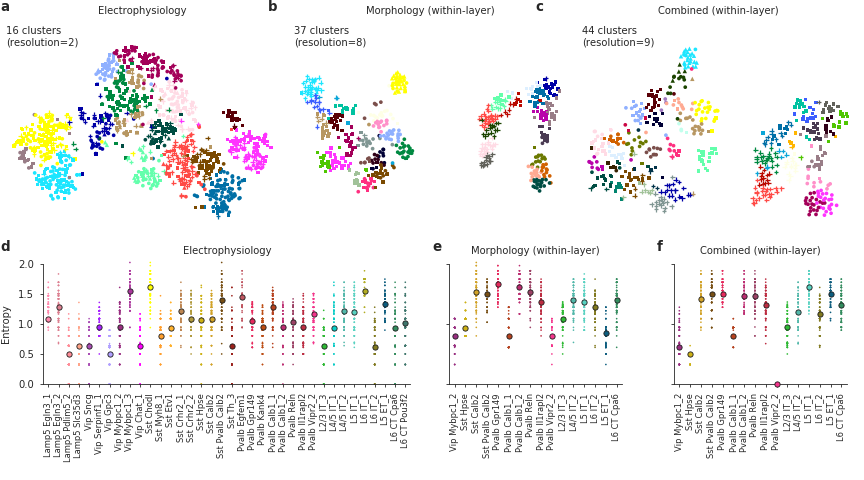

In [56]:
fig = plt.figure(figsize=(7.2, 4))

h = .0125
titles = {'e': 'Electrophysiology', 'm': 'Morphology (within-layer)', 'me': 'Combined (within-layer)'}

ax = plt.axes([.05, .2, h*34, .25])
plot_type_entropies(ax, 'e')
plt.title(titles['e'])

ax = plt.axes([.52,.2, h*16, .25])
plot_type_entropies(ax, 'm', showylabel=False)
plt.title(titles['m'])

ax = plt.axes([.78,.2, h*16, .25])
plot_type_entropies(ax, 'me', showylabel=False)
plt.title(titles['me'])

k = 10
for i,typ in enumerate(['e', 'm', 'me']):
    # kNN graph construction
    A = kneighbors_graph(tsnedata[typ][usedcells[typ]],k)
    sources, targets = A.nonzero()
    G = ig.Graph(directed=True)
    G.add_vertices(A.shape[0])
    edges = list(zip(sources, targets))
    G.add_edges(edges)

    res = 'fine'
    partition = la.find_partition(G, la.RBConfigurationVertexPartition, 
                                  resolution_parameter = resolutions[res][typ], seed=42)
    
    ax = plt.axes([i/3, .5, 0.33,.45])
    plot_tsne(ax, typ, ellipses=False, colors=clusterCols[partition.membership])
    plt.title(titles[typ])
        
    plt.text(.02,.9, '{} clusters\n(resolution={})'.format(
             len(np.unique(partition.membership)), resolutions[res][typ]), 
             transform=ax.transAxes, fontsize=6, ha='left')
    
    sns.despine(ax=ax, left=True, bottom=True)
    
    
fig.text(0, 1, 'a', fontsize=8, fontweight='bold', va='top')
fig.text(.31, 1, 'b', fontsize=8, fontweight='bold', va='top')
fig.text(.62, 1, 'c', fontsize=8, fontweight='bold', va='top')
fig.text(0, .5, 'd', fontsize=8, fontweight='bold', va='top')
fig.text(.5, .5, 'e', fontsize=8, fontweight='bold', va='top')
fig.text(.76, .5, 'f', fontsize=8, fontweight='bold', va='top')
    
plt.savefig('../figures/suppfigures/entropies.png', dpi=300)

# Direct variance variability

In [29]:
from scipy.stats import median_absolute_deviation
from sklearn.cluster import KMeans


def get_type_variability(mode, cutoff=10, restrictLayers=False):

    X = tsnedata[mode][usedcells[mode]]
    keepcells = usedcells[mode]

    C = np.zeros(clusterN) * np.nan

    for t in range(clusterN):
        ind = (ttypes['m1consensus_ass'][keepcells].astype(int) == t)
    
        if np.sum(ind) >= cutoff and restrictLayers:
            l, lc = np.unique(ourLayers[keepcells][ind], return_counts=True)
            mostCommonLayer = l[np.argmax(lc)]
            ind &= (ourLayers[keepcells] == mostCommonLayer)
        
        if np.sum(ind) >= cutoff:
#             C[t] = np.sum(median_absolute_deviation(X[ind,:], axis=0)**2) / np.sum(np.var(X,axis=0))
            C[t] = np.sum(np.var(X[ind,:], axis=0)) / np.sum(np.var(X,axis=0))
            
    return C


def get_cluster_variability(mode, cutoff=10, restrictLayers=False):
    X = tsnedata[mode][usedcells[mode]]
    keepcells = usedcells[mode]
    
    restrict = np.zeros(np.sum(keepcells)).astype(bool)
    k = 0
    
    for t in range(clusterN):
        ind = (ttypes['m1consensus_ass'][keepcells].astype(int) == t)
    
        if np.sum(ind) >= cutoff and restrictLayers:
            l, lc = np.unique(ourLayers[keepcells][ind], return_counts=True)
            mostCommonLayer = l[np.argmax(lc)]
            ind &= (ourLayers[keepcells] == mostCommonLayer)
        
        if np.sum(ind) >= cutoff:
            k += 1
            restrict |= ind
            
#     print(k)
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X[restrict,:])
    
    clusterVars = []
    for t in range(k):
        ind = (kmeans.labels_ == t)
    
#         if np.sum(ind) >= cutoff and restrictLayers:
#             l, lc = np.unique(ourLayers[keepcells][restrict][ind], return_counts=True)
#             mostCommonLayer = l[np.argmax(lc)]
#             ind &= (ourLayers[keepcells][restrict] == mostCommonLayer)
        
        if np.sum(ind) >= cutoff:
#             v = np.sum(median_absolute_deviation(X[restrict,:][ind,:], axis=0)**2) / np.sum(np.var(X,axis=0))
            v = np.sum(np.var(X[restrict,:][ind,:], axis=0)) / np.sum(np.var(X,axis=0))
            clusterVars.append(v)
    return clusterVars


def plot_type_variability(ax, mode, showxlabels=True, showylabel=True):
    C = get_type_variability(mode, restrictLayers=(mode!='e'))
    aboveCutoff = ~np.isnan(C)
    
    plt.sca(ax)
    for i,t in enumerate(np.where(aboveCutoff)[0]):
        plt.scatter(i, C[t], c=clusterColors[t], s=10, edgecolors='k', 
                    linewidth=.5, clip_on=False, zorder=5)
        
    V = get_cluster_variability(mode, restrictLayers = (mode!='e'))
#     for v in V:
#         plt.plot([-.5,np.sum(aboveCutoff)-.5], [v,v], color='#aaaaaa', linewidth=.75, zorder=0)
    rect = matplotlib.patches.Rectangle((-.5,np.min(V)),np.sum(aboveCutoff)+1,np.max(V)-np.min(V),
                             edgecolor='none', facecolor='#bbbbbb', zorder=0)
    ax.add_patch(rect)
        
    if showxlabels:
        plt.xticks(np.arange(np.sum(aboveCutoff)), clusterNames[aboveCutoff], fontsize=5, rotation=90)
    else:
        plt.xticks([])
    plt.ylim([0,1])
#     plt.ylim([np.nanmin(C), np.nanmax(C)])
    plt.xlim([-.5,np.sum(aboveCutoff)-.5])
    if showylabel:
        plt.ylabel('Norm. variance')
    else:
        plt.yticks([0,.5,1], [])
    sns.despine(ax=ax)

<IPython.core.display.Javascript object>


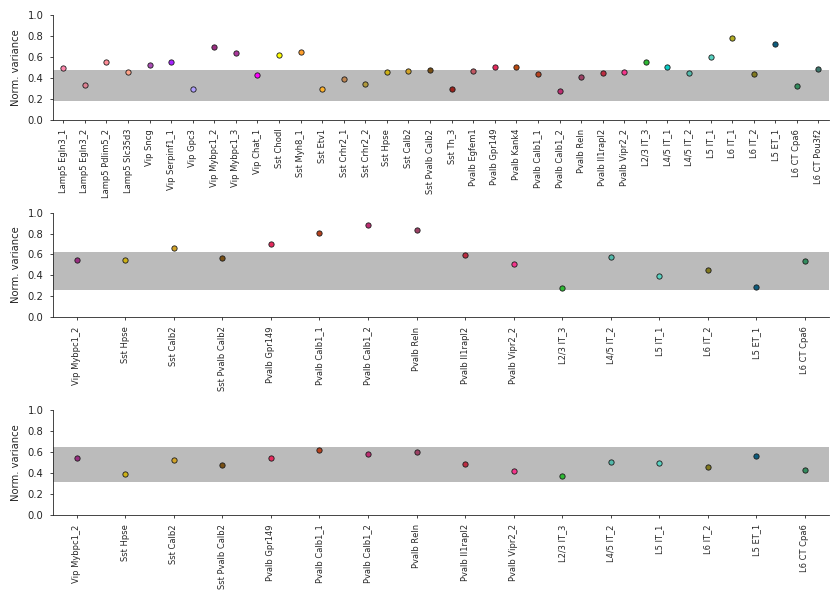

In [30]:
plt.figure(figsize=(7,5))
plt.subplot(311)
plot_type_variability(plt.gca(), 'e')

plt.subplot(312)
plot_type_variability(plt.gca(), 'm')

plt.subplot(313)
plot_type_variability(plt.gca(), 'me')

plt.tight_layout()

In [233]:
# Assemble the figure

In [22]:
# plt.figure(figsize=(7.2, 5.5))

# aspect = 7.2/5.5
# h = .015

# titles = {'e': 'Electrophysiology', 'm': 'Morphology', 'me': 'Electrophysiology + morphology'}

# for i,typ in enumerate(['e', 'm', 'me']):
#     ax = plt.axes([i/3, h*7*aspect*3 + .25, 1/3, .3])
#     plot_tsne(ax, typ, legend=(typ=='e'), ellipses=(typ=='me'))
#     plt.title(titles[typ])
#     sns.despine(ax=ax, left=True, bottom=True)

# for i,typ in enumerate(['e', 'm', 'me']):
#     ax = plt.axes([i/3 + 1/6 - h*7/2, h*7*aspect*2 + .2, h*7, h*7*aspect])
#     plot_family_confusion(ax, typ)

# ax = plt.axes([.05, h*7*aspect + .13, h*42, h*7*aspect])
# plot_type_confusion(ax, 'e')
# plt.title(titles['e'])

# ax = plt.axes([.7, h*7*aspect + .13, h*19, h*7*aspect])
# plot_type_confusion(ax, 'me', showylabels=False)
# plt.title(titles['me'])

# ax = plt.axes([.05,.01, h*42, h*7*aspect])
# # plot_type_entropies(ax, 'e', showxlabels=False)
# plot_type_variability(ax, 'e', showxlabels=False)
# ax.yaxis.set_label_coords(-.05,.5)
# plt.title(titles['e'], y=.85)

# ax = plt.axes([.7,.01, h*19, h*7*aspect])
# # plot_type_entropies(ax, 'me', showylabel=False, showxlabels=False)
# plot_type_variability(ax, 'm', showylabel=False, showxlabels=False)
# plt.title(titles['m'], y=.85)

# # plt.savefig('figures/mainfigures/phenotypes.png', dpi=300)

In [232]:
# GMM clustering

In [231]:
# from sklearn.mixture import GaussianMixture
# from sklearn.decomposition import PCA

# def gmmliks(X, maxK = 100):
#     P = PCA().fit_transform(X)

#     liks = np.zeros((4,maxK))
#     bics = np.zeros((4,maxK))
#     for nc in range(1,maxK):
#         print('.', end='')
#         gmm = GaussianMixture(n_components = nc, covariance_type='diag')
#         gmm.fit(X)
#         liks[0,nc] = gmm.lower_bound_
#         bics[0,nc] = gmm.bic(X)
#         gmm = GaussianMixture(n_components = nc, covariance_type='full')
#         gmm.fit(X)
#         liks[1,nc] = gmm.lower_bound_
#         bics[1,nc] = gmm.bic(X)
#         gmm = GaussianMixture(n_components = nc, covariance_type='diag')
#         gmm.fit(P)
#         liks[2,nc] = gmm.lower_bound_
#         bics[2,nc] = gmm.bic(P)
#         gmm = GaussianMixture(n_components = nc, covariance_type='full')
#         gmm.fit(P)
#         liks[3,nc] = gmm.lower_bound_
#         bics[3,nc] = gmm.bic(P)
    
#     plt.figure(figsize=(6,3))
#     plt.subplot(121)
#     plt.plot(liks[:,1:].T)
#     plt.legend(['diag raw', 'full raw', 'diag PCA', 'full PCA'])
#     plt.title('Log likelihood')
#     plt.subplot(122)
#     plt.plot(bics[:,1:].T)
#     plt.title('BIC')
#     sns.despine()
#     plt.tight_layout()

    
# features_exclude = ['Afterdepolarization (mV)', 'AP Fano factor', 'ISI Fano factor', 
#                     'Latency (ms)', 'Wildness', 'Spike frequency adaptation',
#                     'Sag area (mV*s)', 'Sag time (s)',
#                     'AP amplitude average adaptation index', 'ISI average adaptation index']
# features_log =     ['AP coefficient of variation', 'ISI coefficient of variation', 'ISI adaptation index']
# X = m1.ephys.copy()
# for e in features_log:
#     X[:, m1.ephysNames==e] = np.log(X[:, m1.ephysNames==e])
# X = X[:, ~np.isin(m1.ephysNames, features_exclude)]
# keepcells = ~np.isnan(np.sum(X, axis=1))
# X = X[keepcells, :]
# X = X - X.mean(axis=0)
# X = X / X.std(axis=0)    

# # X = np.concatenate((np.random.randn(100,2),np.random.randn(100,2)*[1,5]+[5,5]))

# X = tsnedata['m'][usedcells['m'],:]

# # morphTsneData[excCells & quantified, inhPC.shape[1]*2+inhZPC.shape[1]:inhPC.shape[1]*2+inhZPC.shape[1]*2] = excZPC

# X = inhChunk

# print(X.shape)
# %time gmmliks(X, maxK=30)
# plt.savefig('figures/gmm-inhibitory-morphometrics.png', dpi=200)

# Assemble the single-type figure

In [31]:
sns_styleset()

with open('../data/processed/ephys/three_traces.pickle', 'rb') as f:
    three_traces = pickle.load(f)
    
import os
swcfiles = {}
for dirpath, dirnames, filenames in os.walk('../data/raw/morph/excitatory/'):
    for filename in [f for f in filenames if f.endswith('.SWC')]:
        swcfiles[filename[:-4]] = os.path.join(dirpath, filename)
for dirpath, dirnames, filenames in os.walk('../data/raw/morph/inhibitory/'):
    for filename in [f for f in filenames if f.endswith('.SWC')]:
        swcfiles[filename[:-4]] = os.path.join(dirpath, filename)
        
print('Found {} .SWC files'.format(len(swcfiles)))
              
for i in np.where(m1.traced)[0]:
    if m1.cells[i] not in swcfiles:
        print('SWC not found: ' + m1.cells[i])
for c in swcfiles:
    if np.sum(m1.cells==c)==0:
        print('Not in the spreadsheet: ' + c + '\n' + swcfiles[c] + '')
    elif ~m1.traced[m1.cells==c]:
        print('Not marked as traced: ' + c)
        
        
def plot_swc(file_path, ax, offset=0, depth=500.0, thickness=1000.0,
             dendrite_color='r', axon_color='darkgreen', soma_color='k', 
             s=.05, minwidth=0, soma_s=3):
    
    swc = pd.read_csv(file_path, delim_whitespace=True, comment='#',
                      names=['n', 'type', 'x', 'y', 'z', 'radius', 'parent'], index_col=False)
    
    dendrites = swc['type'] == 3
    axons = swc['type'] == 2
    soma = swc['type'] == 1
    
    swc['x'] = swc['x']/thickness
    swc['y'] = swc['y']/thickness
        
    soma_loc = swc.iloc[0][['x', 'y']]
    soma_loc['y'] = soma_loc['y'] + depth/thickness
    
    to_plot = np.zeros_like(dendrites)
    if dendrite_color!='none':
        to_plot |= dendrites
    if axon_color!='none':
        to_plot |= axons
    width = np.max(swc['x'][to_plot]) - np.min(swc['x'][to_plot])
    offset += np.abs(np.min(swc['x'][to_plot]-soma_loc['x']))
    if width < minwidth:
        offset += (minwidth-width)/2
        width = minwidth  
    soma_loc['x'] = soma_loc['x'] - offset
    
    if dendrite_color!='none':
        ax.scatter(swc['x'][dendrites]-soma_loc['x'], swc['y'][dendrites]-soma_loc['y'], 
                   s=s, c=dendrite_color, edgecolors='none', rasterized=True)
    if axon_color!='none':
        ax.scatter(swc['x'][axons]-soma_loc['x'], swc['y'][axons]-soma_loc['y'], 
                s=s, c=axon_color, edgecolors='none', rasterized=True)
    if soma_color!='none':
        ax.scatter(swc['x'][soma]-soma_loc['x'], swc['y'][soma]-soma_loc['y'], 
                s=s, c=soma_color, edgecolors='none', rasterized=True)
    else:
        ax.scatter(offset, -depth/thickness, s=soma_s, c='k', edgecolors='none')
        
    return width


def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

Found 646 .SWC files


<IPython.core.display.Javascript object>


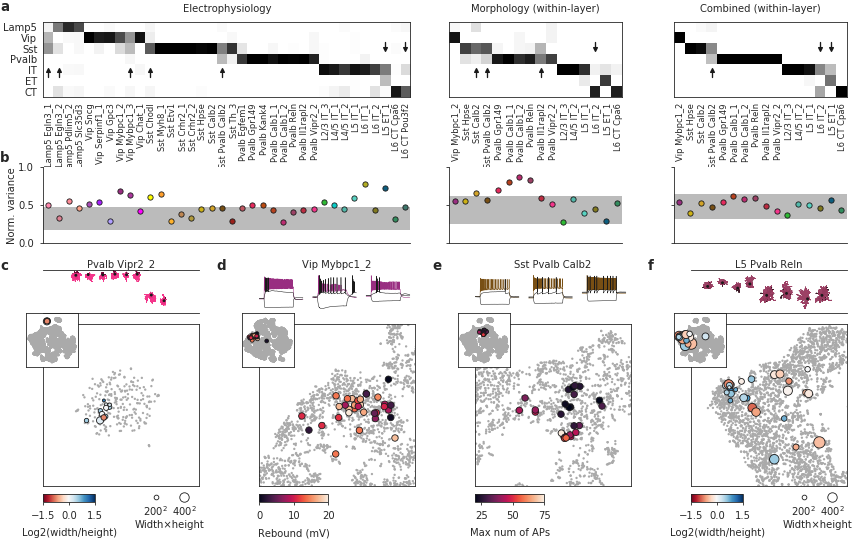

In [32]:
fig = plt.figure(figsize=(7.2, 4.5))

aspect = 7.2/4.5
h = .0125

titles = {'e': 'Electrophysiology', 'm': 'Morphology (within-layer)', 'me': 'Combined (within-layer)'}

ax = plt.axes([.05, h*7*aspect + .68, h*34, h*7*aspect])
plot_type_confusion(ax, 'e')
plt.title(titles['e'])

ax = plt.axes([.52, h*7*aspect + .68, h*16, h*7*aspect])
plot_type_confusion(ax, 'm', showylabels=False)
plt.title(titles['m'])

ax = plt.axes([.78, h*7*aspect + .68, h*16, h*7*aspect])
plot_type_confusion(ax, 'me', showylabels=False)
plt.title(titles['me'])

ax = plt.axes([.05, .55, h*34, h*7*aspect])
# plot_type_entropies(ax, 'e', showxlabels=False)
plot_type_variability(ax, 'e', showxlabels=False)
ax.yaxis.set_label_coords(-.07,.5)
# plt.title(titles['e'], y=.85)
# plt.text(8, .77, 'c', fontsize=7, ha='center')
# plt.text(18, .52, 'd', fontsize=7, ha='center')
# plt.text(33, .82, 'e', fontsize=7, ha='center')

ax = plt.axes([.52,.55, h*16, h*7*aspect])
# plot_type_entropies(ax, 'me', showylabel=False, showxlabels=False)
plot_type_variability(ax, 'm', showylabel=False, showxlabels=False)
# plt.title(titles['m'], y=.85)
# plt.text(7, .87, 'e', fontsize=7, ha='center')
# plt.text(9, .5, 'f', fontsize=7, ha='center')

ax = plt.axes([.78,.55, h*16, h*7*aspect])
# plot_type_entropies(ax, 'me', showylabel=False, showxlabels=False)
plot_type_variability(ax, 'me', showylabel=False, showxlabels=False)
# plt.title(titles['me'], y=.85)

ax_ex1 = plt.axes([.05,.1,.18,.3])
ax_ex2 = plt.axes([.3,.1,.18,.3])
ax_ex3 = plt.axes([.55,.1,.18,.3])
ax_ex4 = plt.axes([.8,.1,.18,.3])

ax_ex1_tiny_t = plt.axes([0.03,.32,.06,.1])
ax_ex2_tiny_t = plt.axes([.28,.32,.06,.1])
ax_ex3_tiny_t = plt.axes([.53,.32,.06,.1])
ax_ex4_tiny_t = plt.axes([.78,.32,.06,.1])

# ax_ex1_cbr  = plt.axes([.05,.07,.08,.015])
ax_ex2_cbr  = plt.axes([.3,.07,.08,.015])
ax_ex3_cbr  = plt.axes([.55,.07,.08,.015])
# ax_ex4_cbr  = plt.axes([.8,.07,.08,.015])

ax_ex1_cbr  = plt.axes([.05,.07,.06,.015])
ax_ex1_leg  = plt.axes([.13,0,.1,.09], zorder=-1)

ax_ex4_cbr  = plt.axes([.8,.07,.06,.015])
ax_ex4_leg  = plt.axes([.88,0,.1,.09], zorder=-1)

ax_ex1_insets = plt.axes([.05,.42,.18,.08])
ax_ex2_insets = plt.axes([.3,.42,.18,.08])
ax_ex3_insets = plt.axes([.55,.42,.18,.08])
ax_ex4_insets = plt.axes([.8,.42,.18,.08])

fig.text(0, 1, 'a', fontsize=8, fontweight='bold', va='top')
fig.text(0, .7, 'b', fontsize=8, fontweight='bold')
fig.text(0, .5, 'c', fontsize=8, fontweight='bold')
fig.text(.25, .5, 'd', fontsize=8, fontweight='bold')
fig.text(.5, .5, 'e', fontsize=8, fontweight='bold')
fig.text(.75, .5, 'f', fontsize=8, fontweight='bold');

In [33]:
plt.sca(ax_ex1_leg)
plt.scatter(0.5,.5, edgecolor='k', linewidth=.5, c='w', cmap='RdBu', vmin=-1.5, vmax=1.5, s=40000/5000)
plt.scatter(1.5,.5, edgecolor='k', linewidth=.5, c='w', cmap='RdBu', vmin=-1.5, vmax=1.5, s=160000/5000)
plt.text(0.5,-1,'$200^2$', fontsize=6, ha='center')
plt.text(1.5,-1,'$400^2$', fontsize=6, ha='center')
plt.text(1,-2,'Width×height', fontsize=6, ha='center')
plt.xlim([-1,2])
plt.ylim([-3,1])
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_ex1_leg, left=True, bottom=True)

plt.sca(ax_ex4_leg)
plt.scatter(0.5,.5, edgecolor='k', linewidth=.5, c='w', cmap='RdBu', vmin=-1.5, vmax=1.5, s=40000/5000)
plt.scatter(1.5,.5, edgecolor='k', linewidth=.5, c='w', cmap='RdBu', vmin=-1.5, vmax=1.5, s=160000/5000)
plt.text(0.5,-1,'$200^2$', fontsize=6, ha='center')
plt.text(1.5,-1,'$400^2$', fontsize=6, ha='center')
plt.text(1,-2,'Width×height', fontsize=6, ha='center')
plt.xlim([-1,2])
plt.ylim([-3,1])
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_ex4_leg, left=True, bottom=True)

In [34]:
selection = (ttypes['type']=='Pvalb Vipr2_2') & (m1.exclude=='') & \
            ~np.isnan(m1.morphometrics[:,m1.morphometricsNames=='axon width'].squeeze())
family = 'pvsst'
print(np.sum(selection))
lims = [[-22,-2],[52,72]]

Z = pickle.load(open('../data/processed/rnaseq/10x-tsne-' + family + '.pickle', 'rb'))
m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))
pos = rnaseqTools.map_to_tsne(m1data[family]['counts'], m1data[family]['genes'],
                              m1.exonCounts[selection,:], m1.genes, Z, knn=10, 
                              newIntronCounts=m1.intronCounts[selection,:],
                              newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
                              normalizeNew=True, normalizeReference=False)

col = np.log2(m1.morphometrics[selection,:][:, m1.morphometricsNames=='axon robust width'].squeeze()/
              m1.morphometrics[selection,:][:, m1.morphometricsNames=='axon robust height'].squeeze())

size = (m1.morphometrics[selection,:][:, m1.morphometricsNames=='axon robust width'].squeeze()*
              m1.morphometrics[selection,:][:, m1.morphometricsNames=='axon robust height'].squeeze())

plt.sca(ax_ex1)
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=2, edgecolor='none', c='#aaaaaa')
plt.scatter(pos[:,0], pos[:,1], edgecolor='k', linewidth=.5, c=col, cmap='RdBu', 
            vmin=-1.5, vmax=1.5, s=size/5000, zorder=2)
plt.scatter(pos[col>1.2,0], pos[col>1.2,1], edgecolor='k', linewidth=.5, c=col[col>1.2], 
            cmap='RdBu', vmin=-1.5, vmax=1.5, s=size[col>1.2]/5000, zorder=3)
plt.xticks([])
plt.yticks([])
plt.xlim(lims[0])
plt.ylim(lims[1])

plt.colorbar(label='Log2(width/height)', orientation='horizontal', cax=ax_ex1_cbr, ticks=[-1.5,0,1.5])

plt.sca(ax_ex1_tiny_t)
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=2, edgecolor='none', c='#aaaaaa')
plt.scatter(pos[:,0], pos[:,1], edgecolor='k', linewidth=.5, c=col, cmap='RdBu', 
            vmin=-1.5, vmax=1.5, s=size/5000, zorder=2)
plt.scatter(pos[col>1.2,0], pos[col>1.2,1], edgecolor='k', linewidth=.5, c=col[col>1.2], 
            cmap='RdBu', vmin=-1.5, vmax=1.5, s=size[col>1.2]/5000, zorder=3)
# plt.plot(lims[0],[lims[1][0], lims[1][0]], linewidth=.5, color='k')
# plt.plot(lims[0],[lims[1][1], lims[1][1]], linewidth=.5, color='k')
# plt.plot([lims[0][0], lims[0][0]], lims[1], linewidth=.5, color='k')
# plt.plot([lims[0][1], lims[0][1]], lims[1], linewidth=.5, color='k')
plt.xticks([])
plt.yticks([]);

12
Using a common set of 493 genes.


In [35]:
examples = np.array([937,940,954,985,986,987,641,1230])

plt.sca(ax_ex1_insets)
plt.title('Pvalb Vipr2_2', pad=0)
plt.axis('equal')

offset = 0
for example in examples:
    col = clusterColors[clusterNames==ttypes['type'][example-2]][0]
    ax_col = col
    den_col = [adjust_lightness(col,.4)]
    w = plot_swc(swcfiles[m1.cells[example-2]], ax=ax_ex1_insets, #depth=500,thickness=1000,
                 depth=m1.depth[example-2], thickness=m1.thickness[example-2],
             axon_color=ax_col, dendrite_color=den_col, soma_color='none', offset=offset)
    offset += w+.1
    
plt.xlim([0,offset])
plt.ylim([-1,0])
# plt.xlim([0,1.1*3-.1])
# plt.ylim([-150,75])
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_ex1_insets, left=True, bottom=False, top=False)

print(np.max(ttypes['m1consensus_boot'],axis=1)[examples-2])

[0.99571429 0.71       0.99       0.99       0.97       0.98714286
 0.72       0.97714286]


In [36]:
typ = 'e'
ttype = 'Vip Mybpc1_2'
featuresToShow = ['Rebound (mV)', 'Sag ratio']
family = 'viplamp'
lims = [[-65,-25], [-5,35]]

selection = usedcells[typ] & (ttypes['type'] == ttype)# & (np.max(m1rna['m1consensus_boot'],axis=1)>.8)
col = m1.ephys[selection,:][:, m1.ephysNames==featuresToShow[0]].squeeze()

plt.sca(ax_ex2)
Z = pickle.load(open('../data/processed/rnaseq/10x-tsne-' + family + '.pickle', 'rb'))
m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=2, edgecolor='none', c='#aaaaaa')
pos = rnaseqTools.map_to_tsne(m1data[family]['counts'], m1data[family]['genes'],
                              m1.exonCounts[selection,:], m1.genes, Z, knn=10, 
                              newIntronCounts=m1.intronCounts[selection,:],
                              newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
                              normalizeNew=True, normalizeReference=False)
plt.scatter(pos[:,0], pos[:,1], c=col, edgecolor='k', linewidth=.5, s = 15, vmin=0, vmax=20)
# for p,n in zip(pos, np.where(selection)[0]):
#     plt.text(p[0], p[1], n+2, fontsize=7)
plt.xlim(lims[0])
plt.ylim(lims[1])
plt.xticks([])
plt.yticks([])
plt.colorbar(label='Rebound (mV)', orientation='horizontal', cax=ax_ex2_cbr)

plt.sca(ax_ex2_tiny_t)
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=2, edgecolor='none', c='#aaaaaa')
plt.scatter(pos[:,0], pos[:,1], c=col, edgecolor='k', linewidth=.5, s = 5, vmin=0, vmax=20)
# plt.plot(lims[0],[lims[1][0], lims[1][0]], linewidth=.5, color='k')
# plt.plot(lims[0],[lims[1][1], lims[1][1]], linewidth=.5, color='k')
# plt.plot([lims[0][0], lims[0][0]], lims[1], linewidth=.5, color='k')
# plt.plot([lims[0][1], lims[0][1]], lims[1], linewidth=.5, color='k')
plt.xticks([])
plt.yticks([]);

# plt.sca(ax_ex1_tiny_ph)
# plt.axis('equal')
# plt.scatter(tsnes[typ][:,0], tsnes[typ][:,1], c='#aaaaaa', s=4, edgecolor='none')
# plt.scatter(tsnes[typ][selection[usedcells[typ]],0], tsnes[typ][selection[usedcells[typ]],1], 
#             c=col, edgecolor='k', linewidth=.5, s = 5)
# plt.xticks([])
# plt.yticks([])

Using a common set of 490 genes.


In [37]:
examples = np.array([865,877,818])

# plt.sca(ax_ex1)
# for example in examples:
#     ind = np.sum(selection[:example-2])
#     plt.scatter(pos[ind,0], pos[ind,1], c='none', edgecolor='r')
    
plt.sca(ax_ex2_insets)
plt.title(ttype, pad=0)

offset = 0
for example in examples:
    col = clusterColors[clusterNames==ttypes['type'][example-2]][0]
    time = three_traces[m1.cells[example-2]][:,3]
    traces = three_traces[m1.cells[example-2]][:,:3]
    timeinterval = time<=.9
    time = time[timeinterval]
    traces = traces[timeinterval,:]
    plt.plot(offset+time, traces[:,2], color=col, linewidth=.3)
    plt.plot(offset+time, traces[:,1], color='k', linewidth=.3)
    plt.plot(offset+time, traces[:,0], color='k', linewidth=.3)
    offset += 1.1
    
plt.xlim([0,1.1*3-.1])
plt.ylim([-150,75])
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_ex2_insets, left=True,bottom=True)

print(np.max(ttypes['m1consensus_boot'],axis=1)[examples-2])

[0.99571429 0.99714286 0.94571429]


In [38]:
# import rnaseqTools
# import sparseRRR
# features_exclude = ['Afterdepolarization (mV)', 'AP Fano factor', 'ISI Fano factor', 
#                     'Latency (ms)', 'Wildness', 'Spike frequency adaptation',
#                     'Sag area (mV*s)', 'Sag time (s)', 'Burstiness',
#                     'AP amplitude average adaptation index', 'ISI average adaptation index',
#                     'Rebound number of APs']
# features_log =     ['AP coefficient of variation', 'ISI coefficient of variation', 'ISI adaptation index']

# Y = m1.ephys.copy()
# for e in features_log:
#     Y[:, m1.ephysNames==e] = np.log(Y[:, m1.ephysNames==e])
# Y = Y[:, ~np.isin(m1.ephysNames, features_exclude)]
# # Y = Y[:, m1.ephysNames=='Rebound (mV)']
# # Y = tsnedata['e'][selection,:]
# Y = ephysTsneFeatures[selection,:]
# Y = Y - np.mean(Y, axis=0)

# genesForRRR = rnaseqTools.geneSelection(m1.counts[selection,:], n=100, threshold=32, decay=1.5, plot=False)
# # genesForRRR = np.isin(m1.genes, m1data[family]['genes'])

# X = m1.counts[selection,:] / np.sum(m1.counts[selection,:], axis=1, keepdims=True) * 1e+6
# X = np.log2(X + 1)
# X = X[:, genesForRRR]
# X = X - np.mean(X, axis=0)
# X = X / np.std(X, axis=0)

# # Y = Y[selection,:] - np.mean(Y[selection,:], axis=0)
# # Y = Y / np.std(Y, axis=0)

# print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

# w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=1, alpha=.5)
# print(m1.genes[genesForRRR][np.where(w[:,0]!=0)[0]])
# print(np.sum(w[:,0]!=0))

In [39]:
# lambdas = np.concatenate([np.arange(.1,2,.1), np.arange(2,10)])
# # lambdas = np.array([.01,.05,.1,.5,1])
# alphas = np.array([.5])

# r2, r2_relaxed, nonzero, corrs, corrs_relaxed = sparseRRR.elastic_rrr_cv(
#     X, Y, rank=2, reps=3, folds=5, alphas=alphas, lambdas=lambdas)

# sparseRRR.plot_cv_results(r2, r2_relaxed, nonzero, corrs, corrs_relaxed, alphas)

In [40]:
# for (a,b) in zip(np.var(Y, axis=0),m1.ephysNames[~np.isin(m1.ephysNames, features_exclude)]):
#     print(a,b)

In [41]:
# sparseRRR.bibiplot(X,Y,w,v,XdimsNames=m1.genes[genesForRRR],
#                    YdimsNames=m1.ephysNames[~np.isin(m1.ephysNames, features_exclude)])

In [42]:
typ = 'e'
ttype = 'Sst Pvalb Calb2'
featuresToShow = ['Max number of APs', 'AP width (ms)']
family = 'pvsst'
lims = [[-25,15], [10,50]]

selection = usedcells[typ] & (ttypes['type'] == ttype)
col = m1.ephys[selection,:][:, m1.ephysNames==featuresToShow[0]].squeeze()

plt.sca(ax_ex3)
Z = pickle.load(open('../data/processed/rnaseq/10x-tsne-' + family + '.pickle', 'rb'))
m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=2, edgecolor='none', c='#aaaaaa')
pos = rnaseqTools.map_to_tsne(m1data[family]['counts'], m1data[family]['genes'],
                              m1.exonCounts[selection,:], m1.genes, Z, knn=10, 
                              newIntronCounts=m1.intronCounts[selection,:],
                              newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
                              normalizeNew=True, normalizeReference=False)
plt.scatter(pos[:,0], pos[:,1], c=col, edgecolor='k', linewidth=.5, s = 15, vmin=20, vmax=75)
plt.xlim(lims[0])
plt.ylim(lims[1])
plt.xticks([])
plt.yticks([])
plt.colorbar(label='Max num of APs', orientation='horizontal', cax=ax_ex3_cbr)

plt.sca(ax_ex3_tiny_t)
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=2, edgecolor='none', c='#aaaaaa')
plt.scatter(pos[:,0], pos[:,1], c=col, edgecolor='k', linewidth=.5, s = 5)
# plt.plot(lims[0],[lims[1][0], lims[1][0]], linewidth=.5, color='k')
# plt.plot(lims[0],[lims[1][1], lims[1][1]], linewidth=.5, color='k')
# plt.plot([lims[0][0], lims[0][0]], lims[1], linewidth=.5, color='k')
# plt.plot([lims[0][1], lims[0][1]], lims[1], linewidth=.5, color='k')
plt.xticks([])
plt.yticks([]);

# plt.sca(ax_ex2_tiny_ph)
# plt.axis('equal')
# plt.scatter(tsnes[typ][:,0], tsnes[typ][:,1], c='#aaaaaa', s=4, edgecolor='none')
# plt.scatter(tsnes[typ][selection[usedcells[typ]],0], tsnes[typ][selection[usedcells[typ]],1], 
#             c=col, edgecolor='k', linewidth=.5, s = 5)
# plt.xticks([])
# plt.yticks([])

Using a common set of 493 genes.


In [43]:
examples = np.array([323,586,585])

# plt.sca(ax_ex1)
# for example in examples:
#     ind = np.sum(selection[:example-2])
#     plt.scatter(pos[ind,0], pos[ind,1], c='none', edgecolor='r')
    
plt.sca(ax_ex3_insets)
plt.title(ttype, pad=0)

offset = 0
for example in examples:
    col = clusterColors[clusterNames==ttypes['type'][example-2]][0]
    time = three_traces[m1.cells[example-2]][:,3]
    traces = three_traces[m1.cells[example-2]][:,:3]
    timeinterval = time<=.9
    time = time[timeinterval]
    traces = traces[timeinterval,:]
    plt.plot(offset+time, traces[:,2], color=col, linewidth=.3)
    plt.plot(offset+time, traces[:,1], color='k', linewidth=.3)
    plt.plot(offset+time, traces[:,0], color='k', linewidth=.3)
    offset += 1.1
    
plt.xlim([0,1.1*3-.1])
plt.ylim([-150,75])
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_ex3_insets, left=True,bottom=True)

print(np.max(ttypes['m1consensus_boot'],axis=1)[examples-2])

[0.99       0.98571429 0.99571429]


In [44]:
# typ='e'
# ttype = 'L5 ET_1'
# featuresToShow = ['Sag ratio', 'ISI adaptation index']
# family = 'exc'
# lims = [[3,5],[-54.5,-52.5]]

# selection = usedcells[typ] & (m1rna['final_type'] == ttype)
# selection[194-2] = False # these two map to tSNE into IT area
# selection[22-2] = False
# col = m1.ephys[selection,:][:, m1.ephysNames==featuresToShow[0]].squeeze()

# plt.sca(ax_ex3)
# Z = pickle.load(open('pickles/10x-tsne-' + family + '.pickle', 'rb'))
# m1data = pickle.load(open('reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))
# plt.axis('equal')
# plt.scatter(Z[:,0], Z[:,1], s=2, edgecolor='none', c='#aaaaaa')
# pos = rnaseqTools.map_to_tsne(m1data[family]['counts'], m1data[family]['genes'],
#                               m1.counts[selection,:], m1.genes, Z, knn=10)
# plt.scatter(pos[:,0], pos[:,1], c=col, edgecolor='k', linewidth=.5, s = 15, vmin=1, vmax=1.5)
# # for p,n in zip(pos, np.where(selection)[0]):
# #     plt.text(p[0], p[1], n+2, fontsize=7)
# plt.xlim(lims[0])
# plt.ylim(lims[1])
# plt.xticks([])
# plt.yticks([])
# plt.colorbar(label='Sag ratio', orientation='horizontal', cax=ax_ex3_cbr)

# plt.sca(ax_ex3_tiny_t)
# plt.axis('equal')
# plt.scatter(Z[:,0], Z[:,1], s=2, edgecolor='none', c='#aaaaaa')
# plt.scatter(pos[:,0], pos[:,1], c=col, edgecolor='k', linewidth=.5, s = 5)
# # plt.plot(lims[0],[lims[1][0], lims[1][0]], linewidth=.5, color='k')
# # plt.plot(lims[0],[lims[1][1], lims[1][1]], linewidth=.5, color='k')
# # plt.plot([lims[0][0], lims[0][0]], lims[1], linewidth=.5, color='k')
# # plt.plot([lims[0][1], lims[0][1]], lims[1], linewidth=.5, color='k')
# plt.xticks([])
# plt.yticks([])

# # plt.sca(ax_ex3_tiny_ph)
# # plt.axis('equal')
# # plt.scatter(tsnes[typ][:,0], tsnes[typ][:,1], c='#aaaaaa', s=4, edgecolor='none')
# # plt.scatter(tsnes[typ][selection[usedcells[typ]],0], tsnes[typ][selection[usedcells[typ]],1], 
# #             c=col, edgecolor='k', linewidth=.5, s = 5)
# # plt.xticks([])
# # plt.yticks([])

In [45]:
# examples = np.array([145,19,70])

# # plt.sca(ax_ex1)
# # for example in examples:
# #     ind = np.sum(selection[:example-2])
# #     plt.scatter(pos[ind,0], pos[ind,1], c='none', edgecolor='r')
    
# plt.sca(ax_ex3_insets)
# plt.title(ttype, pad=0)

# offset = 0
# for example in examples:
#     col = clusterColors[clusterNames==m1rna['final_type'][example-2]][0]
#     time = three_traces[m1.cells[example-2]][:,3]
#     traces = three_traces[m1.cells[example-2]][:,:3]
#     plt.plot(offset+time, traces[:,2], color=col, linewidth=.3)
#     plt.plot(offset+time, traces[:,1], color='k', linewidth=.3)
#     plt.plot(offset+time, traces[:,0], color='k', linewidth=.3)
#     offset += 1.1
    
# plt.xlim([0,1.1*3-.1])
# plt.ylim([-150,75])
# plt.xticks([])
# plt.yticks([])
# sns.despine(ax=ax_ex3_insets, left=True,bottom=True)

# print(np.max(m1rna['m1consensus_boot'],axis=1)[examples-2])

In [46]:
selection = (ourLayers=='5') & (ttypes['type']=='Pvalb Reln') & (m1.exclude=='') & \
            ~np.isnan(m1.morphometrics[:,m1.morphometricsNames=='axon width'].squeeze())
family = 'pvsst'
print(np.sum(selection))
lims = [[-75,-15],[-15,35]]

Z = pickle.load(open('../data/processed/rnaseq/10x-tsne-' + family + '.pickle', 'rb'))
m1data = pickle.load(open('../data/processed/rnaseq/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))
pos = rnaseqTools.map_to_tsne(m1data[family]['counts'], m1data[family]['genes'],
                              m1.exonCounts[selection,:], m1.genes, Z, knn=10, 
                              newIntronCounts=m1.intronCounts[selection,:],
                              newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
                              normalizeNew=True, normalizeReference=False)

col = np.log2(m1.morphometrics[selection,:][:, m1.morphometricsNames=='axon robust width'].squeeze()/
              m1.morphometrics[selection,:][:, m1.morphometricsNames=='axon robust height'].squeeze())

size = (m1.morphometrics[selection,:][:, m1.morphometricsNames=='axon robust width'].squeeze()*
              m1.morphometrics[selection,:][:, m1.morphometricsNames=='axon robust height'].squeeze())

plt.sca(ax_ex4)
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=2, edgecolor='none', c='#aaaaaa')
plt.scatter(pos[:,0], pos[:,1], edgecolor='k', linewidth=.5, c=col, cmap='RdBu', 
            vmin=-1.5, vmax=1.5, s=size/5000, zorder=2)
plt.scatter(pos[col>1.2,0], pos[col>1.2,1], edgecolor='k', linewidth=.5, c=col[col>1.2], 
            cmap='RdBu', vmin=-1.5, vmax=1.5, s=size[col>1.2]/5000, zorder=3)
plt.xticks([])
plt.yticks([])
plt.xlim(lims[0])
plt.ylim(lims[1])

plt.colorbar(label='Log2(width/height)', orientation='horizontal', cax=ax_ex4_cbr, ticks=[-1.5,0,1.5])

plt.sca(ax_ex4_tiny_t)
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=2, edgecolor='none', c='#aaaaaa')
plt.scatter(pos[:,0], pos[:,1], edgecolor='k', linewidth=.5, c=col, cmap='RdBu', 
            vmin=-1.5, vmax=1.5, s=size/5000, zorder=2)
plt.scatter(pos[col>1.2,0], pos[col>1.2,1], edgecolor='k', linewidth=.5, c=col[col>1.2], 
            cmap='RdBu', vmin=-1.5, vmax=1.5, s=size[col>1.2]/5000, zorder=3)
# plt.plot(lims[0],[lims[1][0], lims[1][0]], linewidth=.5, color='k')
# plt.plot(lims[0],[lims[1][1], lims[1][1]], linewidth=.5, color='k')
# plt.plot([lims[0][0], lims[0][0]], lims[1], linewidth=.5, color='k')
# plt.plot([lims[0][1], lims[0][1]], lims[1], linewidth=.5, color='k')
plt.xticks([])
plt.yticks([]);

30
Using a common set of 493 genes.


In [47]:
# selection = (ourLayers=='5') & (ttypes['type']=='Pvalb Reln') & (m1.exclude=='') & \
#             ~np.isnan(m1.morphometrics[:,m1.morphometricsNames=='axon width'].squeeze())
# family = 'pvsst'
# print(np.sum(selection))
# lims = [[-80,-20],[-15,35]]

# Z = pickle.load(open('pickles/10x-tsne-' + family + '.pickle', 'rb'))
# m1data = pickle.load(open('reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))
# pos = rnaseqTools.map_to_tsne(m1data[family]['counts'], m1data[family]['genes'],
#                               m1.exonCounts[selection,:], m1.genes, Z, knn=10, 
#                               newIntronCounts=m1.intronCounts[selection,:],
#                               newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
#                               normalizeNew=True, normalizeReference=False)

cutoff = -52

print(np.mean(ttypes['confidence'][selection][pos[:,0]<cutoff]))
print(np.std(ttypes['confidence'][selection][pos[:,0]<cutoff]))
print((ttypes['confidence'][selection][pos[:,0]<cutoff]).size)

print(np.mean(ttypes['confidence'][selection][pos[:,0]>cutoff]))
print(np.std(ttypes['confidence'][selection][pos[:,0]>cutoff]))
print((ttypes['confidence'][selection][pos[:,0]>cutoff]).size)

0.8559047619047621
0.15450589814747617
15
0.6432380952380952
0.21315541049887357
15


In [48]:
examples = np.array([315,254,671,333,812,82,383,812])

plt.sca(ax_ex4_insets)
plt.title('L5 Pvalb Reln', pad=0)
plt.axis('equal')

offset = 0
for example in examples:
    col = clusterColors[clusterNames==ttypes['type'][example-2]][0]
    ax_col = col
    den_col = [adjust_lightness(col,.4)]
    w = plot_swc(swcfiles[m1.cells[example-2]], ax=ax_ex4_insets, #depth=500,thickness=1000,
                 depth=m1.depth[example-2], thickness=m1.thickness[example-2],
             axon_color=ax_col, dendrite_color=den_col, soma_color='none', offset=offset)
    offset += w+.1
    
plt.xlim([0,offset])
plt.ylim([-1,0])
# plt.xlim([0,1.1*3-.1])
# plt.ylim([-150,75])
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_ex4_insets, left=True, top=False)

print(np.max(ttypes['m1consensus_boot'],axis=1)[examples-2])

[0.94       0.90428571 0.94714286 0.83714286 0.76       0.72285714
 0.64714286 0.76      ]


In [49]:
# typ = 'e'
# ttype = 'Sst Myh8_1'
# featuresToShow = ['Rebound (mV)', 'Membrane time constant (ms)']
# family = 'pvsst'
# lims = [[40,80], [-30,10]]

# selection = usedcells[typ] & (m1rna['final_type'] == ttype)
# col = m1.ephys[selection,:][:, m1.ephysNames==featuresToShow[0]].squeeze()

# plt.sca(ax_ex4)
# Z = pickle.load(open('pickles/10x-tsne-' + family + '.pickle', 'rb'))
# m1data = pickle.load(open('reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))
# plt.axis('equal')
# plt.scatter(Z[:,0], Z[:,1], s=2, edgecolor='none', c='#aaaaaa')
# pos = rnaseqTools.map_to_tsne(m1data[family]['counts'], m1data[family]['genes'],
#                               m1.counts[selection,:], m1.genes, Z, knn=10)
# plt.scatter(pos[:,0], pos[:,1], c=col, edgecolor='k', linewidth=.5, s = 15, vmin=0, vmax=20)
# plt.xlim(lims[0])
# plt.ylim(lims[1])
# plt.xticks([])
# plt.yticks([])
# plt.colorbar(label='Sag ratio')
# plt.title(ttype)

# plt.sca(ax_ex4_tiny_t)
# plt.axis('equal')
# plt.scatter(Z[:,0], Z[:,1], s=2, edgecolor='none', c='#aaaaaa')
# plt.scatter(pos[:,0], pos[:,1], c=col, edgecolor='k', linewidth=.5, s = 5)
# plt.xticks([])
# plt.yticks([])

# # plt.sca(ax_ex4_tiny_ph)
# # plt.axis('equal')
# # plt.scatter(tsnes[typ][:,0], tsnes[typ][:,1], c='#aaaaaa', s=4, edgecolor='none')
# # plt.scatter(tsnes[typ][selection[usedcells[typ]],0], tsnes[typ][selection[usedcells[typ]],1], 
# #             c=col, edgecolor='k', linewidth=.5, s = 5)
# # plt.xticks([])
# # plt.yticks([])

In [50]:
plt.savefig('../figures/mainfigures/singletypes.png', dpi=400)